### Libraries

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, MaxPooling2D,\
                                    Conv2D, Conv2DTranspose, LeakyReLU, Dropout

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

### Dataset

In [8]:
# Params
PATH_DATASET = r"D:\BigDataSets\ImageGeneration\face_thumbnails128x128"
BATCH_SIZE = 64

# Dataset (https://www.kaggle.com/datasets/greatgamedota/ffhq-face-data-set)
dataset_train = image_dataset_from_directory(PATH_DATASET, labels=None, batch_size=BATCH_SIZE,
                                             image_size=(64, 64), smart_resize=True,
                                             validation_split=0.05, seed=777, subset="training")
dataset_val = image_dataset_from_directory(PATH_DATASET, labels=None, batch_size=BATCH_SIZE,
                                           image_size=(64, 64), seed=777, smart_resize=True,
                                           validation_split=0.05, subset="validation")
dataset_train = dataset_train.map(lambda img: img / 255)
dataset_val = dataset_train.map(lambda img: img / 255)

Found 70000 files belonging to 1 classes.
Using 66500 files for training.
Found 70000 files belonging to 1 classes.
Using 3500 files for validation.


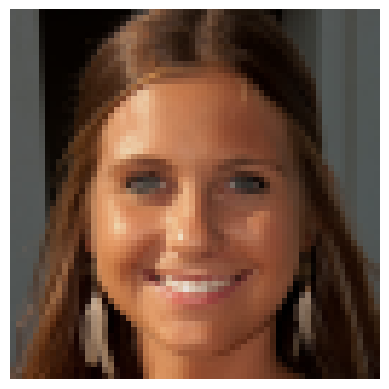

In [9]:
for x in dataset_train:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [14]:
HIDDEN_DIM = 128
# KWARGS_INIT = {'kernel_initializer': RandomNormal(mean=0., stddev=0.02)}  KWARGS_INIT | 
KWARGS_CONV = {'padding': 'same'}
KWARGS_CONV_D = KWARGS_CONV | {'activation': LeakyReLU(0.2)}

In [13]:
discriminator = keras.Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(64, kernel_size=4, strides=1, **KWARGS_CONV_D),
    Conv2D(128, kernel_size=4, strides=2, **KWARGS_CONV_D),
    Conv2D(128, kernel_size=4, strides=2, **KWARGS_CONV_D),
    Conv2D(256, kernel_size=4, strides=2, **KWARGS_CONV_D),
    Flatten(),
    Dropout(0.2),  # Защита от шума генератора
    Dense(1, activation="sigmoid")],
    name="discriminator")

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dropout (Dropout)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1)               

In [16]:
generator = keras.Sequential([
    Input(shape=(HIDDEN_DIM,)),
    Dense(8 * 8 * 128),
    Reshape((8, 8, 128)),
    Conv2DTranspose(128, kernel_size=4, strides=2, **KWARGS_CONV_D),
    Conv2DTranspose(256, kernel_size=4, strides=2, **KWARGS_CONV_D),
    Conv2DTranspose(512, kernel_size=4, strides=2, **KWARGS_CONV_D),
    Conv2D(3, kernel_size=5, padding="same", activation="sigmoid")],
    name="generator")

In [17]:
discriminator.summary()
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dropout (Dropout)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1)               